In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import datasets
import itertools

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Dense, Input, merge
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from keras.utils import np_utils
import numpy as np

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# Load Data

In [2]:
def laod_data():
    # Load the data
    train = pd.read_csv("./train.csv")
    test = pd.read_csv("./test.csv")

    print(train.head())
    print("**********")
    print(test.head())

    Y_train = train["label"]
    X_train = train.drop(labels = ["label"],axis = 1)  # Drop 'label' column

    # free some space
    del train 

    Y_train, X_train, test = preprocess(Y_train, X_train, test)
    
    return Y_train, X_train, test

# Preprocessing

In [3]:
def preprocess(Y_train, X_train, test):
    # Check the data
    g = sns.countplot(Y_train)
    Y_train.value_counts()

    print(X_train.isnull().any().describe())
    print("**********")
    print(test.isnull().any().describe())
    
    # Normalize the data (画素値を0-1に)
    X_train = X_train / 255.0
    test = test / 255.0
    
    # Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
    # reshapeで[データ数, height, width, color_channels]
    X_train = X_train.values.reshape(-1,28,28,1)
    test = test.values.reshape(-1,28,28,1)

    # Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
    #Y_train = to_categorical(Y_train, num_classes = 10)
    
    return Y_train, X_train, test

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

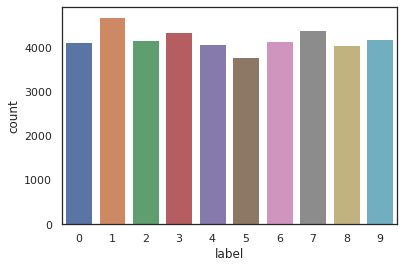

In [5]:
Y_train, X_train, test = laod_data()

In [6]:
# Split training and valdiation set
# Set the random seed
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, \
                                                test_size = 0.1, random_state=random_seed)

In [7]:
try : 
    # shape: (train dataの個数) * 28 * 28
    train_size, h_size, w_size, shape2 = X_train.shape
    X_train = np.reshape(X_train, newshape=(train_size, h_size, w_size))
    # shape: (validation dataの個数) * 28 * 28
    val_size, h_size, w_size, shape1 = X_val.shape
    X_val = np.reshape(X_val, newshape=(val_size, h_size, w_size))
    
    # shape: (train dataの個数) * 1
    Y_train = np.array(Y_train)
    # shape: (validation dataの個数) * 1
    Y_val = np.array(Y_val)
except:
    print("already reshaped")

print(Y_train.shape)
print(Y_val.shape)
print(X_train.shape)
print(X_val.shape)

(37800,)
(4200,)
(37800, 28, 28)
(4200, 28, 28)


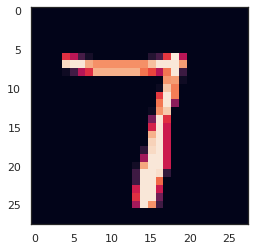

In [8]:
# Some examples
g = plt.imshow(X_train[1][:,:])

# 次のTodo
- (実装)
- 済：このHPの実装
https://cpp-learning.com/siamese-network/

- 済：このHPの実装
http://ni4muraano.hatenablog.com/entry/2019/01/06/145827
- ★：入力画像サイズの動的な変換機能の追加
- ★：現在の見比べネット・Siamese Networkの新潟iDを使った性能比較（但し，validation lossやaccuracyが現在の見比べネットでもある程度精度出ているので，これでいいのかもしれない．．）
- ★：siamese networkの実装
- ★：embeddingの描写

- (質問)
- ★：marginっていくらで定義されるのか？

- (イメージ掴み)
- 済：open-cvのinstall
- 済：siamese networkとは
- 済：embeddingとは
- 済：sphereface, cosface, arcfaceとは

# Construct Model

In [9]:
from __future__ import print_function
import numpy as np
import random
 
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

In [10]:
num_classes = 10 # 0～9

In [11]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [12]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [13]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    
    （方針）
    ・各数字に対するインデックスを取得する
    ・インデックスから，同じペアとランダムなペア（%を使うと良い）を作る．
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [37]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [38]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
  
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

ペア画像作成

In [16]:
# create trainng+test positive and negative pairs

# トレーニングデータ
# digit_indices (indicesはindexの複数形)．ある数字がどのラベルに入ってるかを表示
digit_indices = [np.where(Y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)
 
# バリデーションデータ
digit_indices = [np.where(Y_val == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(X_val, digit_indices)

print(np.shape(tr_pairs))

(68440, 2, 28, 28)


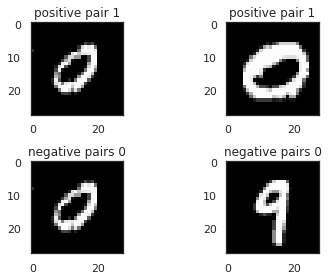

In [17]:
# 描写
plt.subplot(2,2,1)
plt.imshow(tr_pairs[0][0], cmap='gray')
plt.title("positive pair {}".format(tr_y[0]))
 
plt.subplot(2,2,2)
plt.imshow(tr_pairs[0][1], cmap='gray')
plt.title("positive pair {}".format(tr_y[0]))
 
plt.subplot(2,2,3)
plt.imshow(tr_pairs[1][0], cmap='gray')
plt.title("negative pairs {}".format(tr_y[1]))
 
plt.subplot(2,2,4)
plt.imshow(tr_pairs[1][1], cmap='gray')
plt.title("negative pairs {}".format(tr_y[1]))
 
plt.tight_layout()
plt.show()

# 学習と精度確認

In [18]:
input_shape = (h_size, w_size)

In [19]:
# network definition
base_network = create_base_network(input_shape)
 
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)
 
model.summary()
tf.keras.utils.plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [20]:
print(tr_pairs.shape)
print(tr_pairs[:,0].shape) # ペアの１組目
print(tr_pairs[:,1].shape) # ペアの2組目
print(tr_y.shape) # ペアのラベル. 0か1が入ってる

(68440, 2, 28, 28)
(68440, 28, 28)
(68440, 28, 28)
(68440,)


Train on 68440 samples, validate on 7420 samples
68440/68440 [==============================] - 7s 97us/sample - loss: 0.1138 - accuracy: 0.8601 - val_loss: 0.0580 - val_accuracy: 0.9327


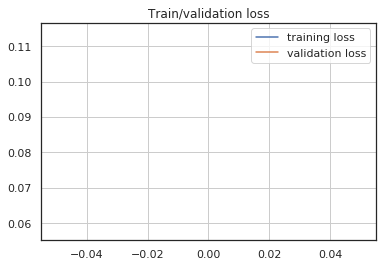

In [21]:
# train
tr_y = tf.cast(tr_y, dtype='float32') #tf.castは型変換に用いる
te_y = tf.cast(te_y, dtype='float32')
    
rms = RMSprop() # 最適化方式を決定する．
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy]) 
 
H = model.fit(x = [tr_pairs[:, 0], tr_pairs[:, 1]], y = tr_y,
          batch_size=128,
          epochs = 1,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y,))
 
plt.title('Train/validation loss')
plt.plot(H.history['loss'], label = 'training loss')
plt.plot(H.history['val_loss'], label = 'validation loss')
plt.grid()
plt.legend()
plt.show()

In [22]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]]) # training data
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]]) # validation data
te_acc = compute_accuracy(te_y, y_pred)
 
print('Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('Accuracy on test set: %0.2f%%' % (100 * te_acc))

Accuracy on training set: 94.46%
Accuracy on test set: 93.27%


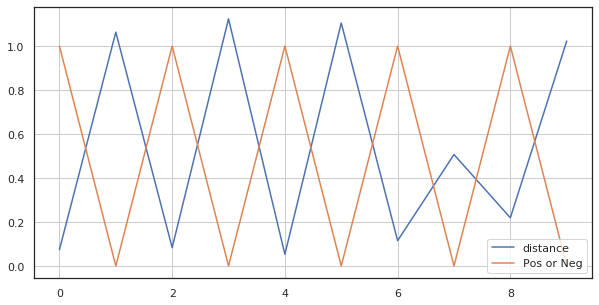

In [23]:
plt.figure(figsize = (10,5))
plt.plot(y_pred[0:10], label='distance')
# plt.bar(range(0, 10), te_y[0:10])
plt.plot(te_y[0:10],label='Pos or Neg')
plt.legend()
plt.grid()
plt.show()

In [9]:
import os, random, cv2
import numpy as np

class SiameseDataLoader(object):
    def __init__(self, root_train_folder_path, samples_per_class, grayscale=False):
        self._root_train_folder_path = root_train_folder_path
        self._samples_per_class = samples_per_class
        self._sample_file_names = self._get_samples()
        self._grayscale = grayscale
        if self._grayscale:
            image = cv2.imread(self._sample_file_names[0][0], cv2.IMREAD_GRAYSCALE)
            self.input_shape = (image.shape[0], image.shape[1], 1)
        else:
            image = cv2.imread(self._sample_file_names[0][0])
            self.input_shape = image.shape

    def get_train_data(self):
        # positiveとnegativeの画像ペアファイルパスを受け取る
        pairs, labels = self._create_pairs(self._sample_file_names, self._samples_per_class)
        tmp = cv2.imread(pairs[0][0])
        if self._grayscale:
            X1 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], 1), np.float32)
            X2 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], 1), np.float32)
        else:
            X1 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], tmp.shape[2]), np.float32)
            X2 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], tmp.shape[2]), np.float32)
        Y = np.zeros((len(pairs), 1), dtype=np.float32)
        i = 0
        if self._grayscale:
            for pair, label in zip(pairs, labels):
                x1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
                X1[i] = x1[:,:,np.newaxis]
                x2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
                X2[i] = x2[:,:,np.newaxis]
                Y[i] = labels[i]
                i += 1
        else:
            for pair, label in zip(pairs, labels):
                X1[i] = cv2.imread(pair[0])
                X2[i] = cv2.imread(pair[1])
                Y[i] = labels[i]
                i += 1
        return [self._normalize(X1), self._normalize(X2)], Y

    def _get_samples(self):
        sample_file_names = []
        folders = os.listdir(self._root_train_folder_path)
        for folder_name in folders:
            folder_path = self._root_train_folder_path + folder_name
            if os.path.isdir(folder_path):
                files = os.listdir(folder_path)
                sample_file_names_per_class = []
                for file in files:
                    sample_file_names_per_class.append(folder_path + os.sep + file)
                sample_file_names.append(sample_file_names_per_class)
        return sample_file_names

    def _create_pairs(self, sample_file_names, samples_per_class):
        positive_pairs, positive_labels = self._create_positive_pairs(sample_file_names, samples_per_class)
        negative_pairs, negative_labels = self._create_negative_pairs(sample_file_names, samples_per_class)
        positive_pairs.extend(negative_pairs)
        positive_labels.extend(negative_labels)

        return positive_pairs, positive_labels

    # 手書き数字の0と0等同じクラスのペアを作成するためのメソッド
    def _create_positive_pairs(self, sample_file_names, samples_per_class):
        positive_pairs = []
        for sample_file_names_per_class in sample_file_names:
            for k in range(samples_per_class):
                positive_pairs.append(random.sample(sample_file_names_per_class, 2))
        labels = [1]*len(positive_pairs)
        return positive_pairs, labels

    # 手書き数字の2と3等異なるクラスのペアを作成するためのメソッド
    def _create_negative_pairs(self, sample_file_names, samples_per_class):
        negative_pairs = []
        class_count = len(sample_file_names)
        for i, sample_file_names_per_class in enumerate(sample_file_names):
            class_ids = list(range(class_count))
            class_ids.remove(i)
            for k in range(samples_per_class):
                pair = []
                pair.append(random.choice(sample_file_names[i]))
                pair.append(random.choice(sample_file_names[random.choice(class_ids)]))
                negative_pairs.append(pair)
        labels = [0]*len(negative_pairs)
        return negative_pairs, labels

    def _normalize(self, X):
        return X/255

    def get_test_data(self, test_image_path, samples_per_class):
        pairs = []
        for sample_file_names_per_class in self._sample_file_names:
            selected_files = random.sample(sample_file_names_per_class, samples_per_class)
            for selected_file in selected_files:
                pair = []
                pair.append(test_image_path)
                pair.append(selected_file)
                pairs.append(pair)
        tmp = cv2.imread(pairs[0][0])
        if self._grayscale:
            X1 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], 1), np.float32)
            X2 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], 1), np.float32)
            for i, pair in enumerate(pairs):
                X1[i] = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)[:,:,np.newaxis]
                X2[i] = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)[:,:,np.newaxis]
        else:
            X1 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], tmp.shape[2]), np.float32)
            X2 = np.zeros((len(pairs), tmp.shape[0], tmp.shape[1], tmp.shape[2]), np.float32)
            for i, pair in enumerate(pairs):
                X1[i] = cv2.imread(pair[0])
                X2[i] = cv2.imread(pair[1])
        return [self._normalize(X1), self._normalize(X2)]

ModuleNotFoundError: No module named 'cv2'

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Lambda, Conv2D, Activation, MaxPool2D, BatchNormalization, Dropout, Flatten
import keras.backend as K

class SiameseNet(object):
    def __init__(self, input_shape, feature_dim):
        seq = Sequential()
        seq.add(Conv2D(16, 3, padding='same', input_shape=input_shape))
        seq.add(BatchNormalization())
        seq.add(Activation('relu'))
        seq.add(MaxPool2D())

        seq.add(Conv2D(32, 3, padding='same'))
        seq.add(BatchNormalization())
        seq.add(Activation('relu'))
        seq.add(MaxPool2D())

        seq.add(Conv2D(64, 3, padding='same'))
        seq.add(BatchNormalization())
        seq.add(Activation('relu'))
        seq.add(MaxPool2D())

        seq.add(Flatten())
        seq.add(Dense(256, activation='sigmoid'))
        seq.add(Dropout(0.2))
        seq.add(Dense(feature_dim, activation='linear'))

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        processed_a = seq(input_a)
        processed_b = seq(input_b)
        distance = Lambda(self._euclidean_distance, output_shape=self._eucl_dist_output_shape)([processed_a, processed_b])
        self._model = Model(inputs=[input_a, input_b], outputs=distance)

    def _euclidean_distance(self, vects):
        x, y = vects
        distance = K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
        return distance

    def _eucl_dist_output_shape(self, shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    def get_model(self):
        return self._model

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true*K.square(y_pred) + (1 - y_true)*K.square(K.maximum(margin - y_pred, 0)))

In [11]:
from siamese_net import SiameseNet
from keras.optimizers import RMSprop
from siamese_data_loader import SiameseDataLoader
import os

if __name__ == '__main__':
    iterations = 10000
    samples_per_class = 5
    feature_dim = 10
    grayscale = True
    # Adam not works well for Siamese net
    optim = RMSprop(decay=1e-4)
    #optim = Adam(lr=0.0001, decay=1e-4, amsgrad=True)

    loader_train = SiameseDataLoader('train' + os.sep, samples_per_class, grayscale)
    loader_val = SiameseDataLoader('val' + os.sep, samples_per_class, grayscale)

    siamese = SiameseNet(loader_train.input_shape, feature_dim).get_model()
    siamese.compile(optimizer=optim, loss=contrastive_loss)
    min_loss = 9999
    min_iter = -1
    for iteration in range(iterations):
        X, y = loader_train.get_train_data()
        loss_train = siamese.train_on_batch(X, y)
        if (iteration+1)%100 == 0:
            X, y = loader_val.get_train_data()
            loss_val = siamese.evaluate(X, y, verbose=0)
            if loss_val < min_loss:
                min_iter = iteration
                min_loss = loss_val
                siamese.save_weights('weights.h5', True)
            print('loss@' + str(iteration) + ' = ' + str(loss_train) + ',' + str(loss_val) + ' (' + str(min_loss) + '@' + str(min_iter) + ')')

ModuleNotFoundError: No module named 'siamese_net'

In [12]:
from siamese_net import SiameseNet, contrastive_loss
import numpy as np
from keras.optimizers import RMSprop
from siamese_data_loader import SiameseDataLoader
import os

# Siamese Networkはペア画像との距離を返してくるので、
# 一番近い距離の画像が所属しているクラスを予測クラスとする
def distance_to_class(y, classes, samples_per_class):
    i = 0
    class_distances = []
    for c in range(classes):
        distances = []
        for s in range(samples_per_class):
            distances.append(y[i])
            i += 1
        median = np.median(np.array(distances))
        class_distances.append(median)
    return np.argmin(np.array(class_distances))

if __name__ == '__main__':
    samples_per_class = 5
    feature_dim = 10
    grayscale = True
    optim = RMSprop(decay=1e-4)
    test_root_path = 'test' + os.sep
    classes = 10

    loader = SiameseDataLoader('train' + os.sep, samples_per_class, grayscale)

    siamese = SiameseNet(loader.input_shape, feature_dim).get_model()
    siamese.compile(optimizer=optim, loss=contrastive_loss)
    siamese.load_weights('weights.h5')

    correct = 0
    count = 0
    for c in range(classes):
        test_class_folder_path = test_root_path + str(c) + os.sep
        test_file_names = os.listdir(test_class_folder_path)
        distances = []
        for test_file_name in test_file_names:
            test_file_path = test_class_folder_path + test_file_name
            X = loader.get_test_data(test_file_path, samples_per_class)
            y = siamese.predict_on_batch(X)
            predicted_class = distance_to_class(y, classes, samples_per_class)
            if predicted_class == c:
                correct += 1
            count += 1
    accuracy = correct/count*100
    print('accuracy=' + str(accuracy))

ModuleNotFoundError: No module named 'siamese_net'

In [14]:
#modelの構造保存
json_string = cam_model.to_json()
open('digit_recognizer_model.json', 'w').write(json_string)

#重みの保存
cam_model.save_weights('digit_recognizer_weights.h5')

In [15]:
# モデルと重みの読込，
from keras.models import model_from_json
cam_model = model_from_json(open('digit_recognizer_model.json', 'r').read())
cam_model.load_weights('digit_recognizer_weights.h5')

#summaryをテキストとして保存
with open("output.txt", "w") as fp:
    cam_model.summary(print_fn=lambda x: fp.write(x + "\r\n"))

# Results

In [87]:
# 対象のmodel名を入れる
history = ab_model_history.history

In [91]:
ab_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 28, 28, 32)   832         input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 28, 28, 64)   51264       conv2d_156[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_157[0][0]                 
___________________________________________________________________________________________

In [ ]:
loss,dense_11_loss,dense_13_loss,dense_11_accuracy,dense_13_accuracyの5つ

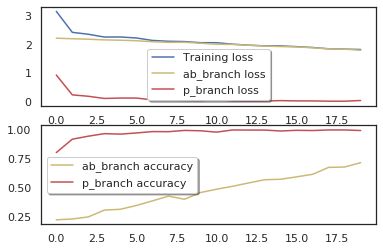

In [102]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history['loss'], color='b', label="Training loss")
ax[0].plot(history['activation_32_loss'], color='y', label="ab_branch loss")
ax[0].plot(history['dense_51_loss'], color='r', label="p_branch loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history['activation_32_accuracy'], color='y',label="ab_branch accuracy")
ax[1].plot(history['dense_51_accuracy'], color='r',label="p_branch accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Attention Map

In [105]:
from keras import backend as K #Keras API

#中間層の結果を取得
layer_name = 'activation_33'
intermediate_layer_model = Model(inputs=ab_model.input,
                                 outputs=ab_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train[2000:3000])
print(np.shape(intermediate_output))

# Keras APIを使用
#ret = cam_model.predict(X_train[0:1], 1, 1)
# get_layer_output = K.function([cam_model.get_layer(layer_name).input],
#                                   [cam_model.get_layer(layer_name).output])
# layer_output = get_layer_output([X_train[0:1],])
# print(np.shape(layer_output))
np.save('./attention_map.npy', intermediate_output, allow_pickle=False)

(1000, 14, 14, 64)


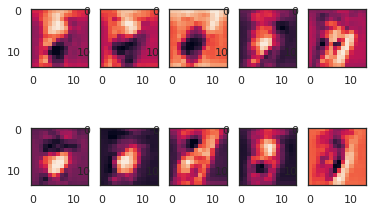

In [109]:
for i in range(0,10):
    plt.subplot(2,5,i+1)
    plt.imshow(intermediate_output[0,:,:,i])

## Confusion Matrxi

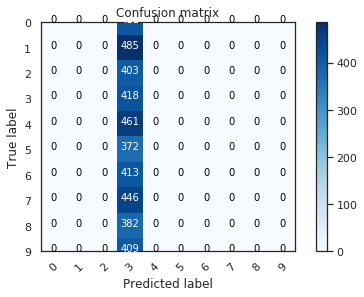

In [30]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cam_model.predict(X_val)
# Convert predictions classes "FROM" one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations "FROM" one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

#あるカラムだけ1で他のカラムは0な行列の表現。カテゴリー変数でよく使います。
#古典的な統計の教科書では「ダミー変数」という言い方もします。
#PandasのOneHotベクトルを作る関数get_dummiesはこれが由来です。

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Error results

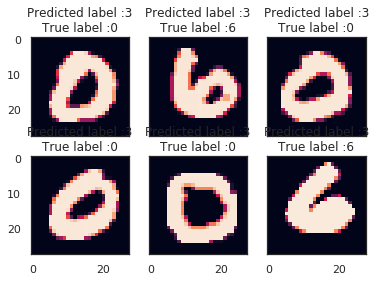

In [31]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Predict Test_data

# Predict test data

In [66]:
# predict results
results = cam_model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [ ]:
# data_num * class_num
print(results.shape)

predicted = np.argmax(results, axis = 1)
print(predicted)

# Grad-Cam ++

In [70]:
#import PIL
import numpy as np
import argparse
import keras
import sys
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
#import cv2

In [29]:
def Grad_Cam_plus_plus(input_model, layer_name, x, row, col):

    model = input_model

    # 前処理
    #X = np.expand_dims(x, axis=0)
    #X = X.astype('float32')
    #preprocessed_input = X / 255.0

    # 予測クラスの算出
    #predictions = model.predict(preprocessed_input)
    print("入力：" + str(x.shape))
    predictions = model.predict(x)
    class_idx = np.argmax(predictions[0])

    #  使用する重みの抽出、高階微分の計算
    class_output = model.layers[-1].output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    #first_derivative：１階微分
    first_derivative = K.exp(class_output)[0][class_idx] * grads
    #second_derivative：２階微分
    second_derivative = K.exp(class_output)[0][class_idx] * grads * grads
    #third_derivative：３階微分
    third_derivative = K.exp(class_output)[0][class_idx] * grads * grads * grads

    #関数の定義
    gradient_function = K.function([model.input], [conv_output, first_derivative, second_derivative, third_derivative])  # model.inputを入力すると、conv_outputとgradsを出力する関数


    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = gradient_function([x])
    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = conv_output[0], conv_first_grad[0], conv_second_grad[0], conv_third_grad[0]

    #alphaを求める
    global_sum = np.sum(conv_output.reshape((-1, conv_first_grad.shape[2])), axis=0)
    alpha_num = conv_second_grad
    alpha_denom = conv_second_grad*2.0 + conv_third_grad*global_sum.reshape((1,1,conv_first_grad.shape[2]))
    alpha_denom = np.where(alpha_denom!=0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    #alphaの正規化
    alpha_normalization_constant = np.sum(np.sum(alphas, axis = 0), axis = 0)
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
    alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad.shape[2]))

    #wの計算
    weights = np.maximum(conv_first_grad, 0.0)
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad.shape[2])))

    #Lの計算
    grad_CAM_map = np.sum(deep_linearization_weights * conv_output, axis=2)
    grad_CAM_map = np.maximum(grad_CAM_map, 0)
    grad_CAM_map = grad_CAM_map / np.max(grad_CAM_map)
    
    #ヒートマップを描く
    print("出力：" + str(np.shape(grad_CAM_map)))
    #grad_CAM_map = cv2.resize(grad_CAM_map, (row, col), cv2.INTER_LINEAR)
    #jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    #jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return grad_CAM_map

In [26]:
# layer_name : 最後のconvolution層直後のactivation層の名前を確認したい．
# activation層（活性化関数を使っている層）がconvolution層に含まれている場合
# ⇒ convolution層の名前でよい．
# 層の名前はmodel.summary()で確認できる．
model.summary()
# これよりconv2d_4が対象のactivation層になる

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [30]:
#次のTodo★
#以下の関数を通るようにする．（上で実装したpredictionを通るようにする．）
 
#from keras.applications.vgg16 import VGG16
from keras import backend as K

# Model : 上で定義したmodel
model = model

#Model : VGG16 (.h5のダウンロードに10分かかる)
#model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

#Model : Resvet(.h5のダウンロードに10分かかる)
#model = ResNet50(weights = 'imagenet')

img = test[0:5] #shapeは datanum(5) * 28pix * 28pix * 1の形に

target_layer = 'conv2d_4'
row = 28
col = 28

img_GCAMplusplus = Grad_Cam_plus_plus(model, target_layer, img, row, col)
#img_Gplusplusname = args.image_path+"_GCAM++_%s.jpg"%args.model
#cv2.imwrite(img_Gplusplusname, img_GCAMplusplus)

入力：(5, 28, 28, 1)
出力：(14, 14)


In [34]:
# 次回Todo
# cv2をimportして以下の計算を回す．

In [33]:
img_GCAMplusplus_resized = img_GCAMplusplus.resize((28,28))

ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [ ]:
#grad_CAM_map = cv2.resize(grad_CAM_map, (row, col), cv2.INTER_LINEAR)
#jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
#jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

In [56]:
img_GCAMplusplus.shape

(14, 14)

## FCN

In [1]:
# FCN
# Todo : 
# ★model.summary()で画像サイズを見る。
# ★画像の切り出しについて調べる。（labelmeをインストールhttps://github.com/wkentaro/labelme）
# ★実際に学習と予測をしてみる。

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy

import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        n = s[0]
        if s[1] == None:
            h = None
        else:
            h = s[1] + 2 * self.padding[0]
        if s[2] == None:
            w = None
        else:
            w = s[2] + 2 * self.padding[1]
        c = s[3]
        return (n, h, w, c)

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

class UserModel(object):

    def __init__(self, cut_size, channel, category_count, optimizer):
        self.cut_size = cut_size
        self.channel = channel
        self.category_count = category_count
        self.optimizer = optimizer

    def __denseBlock(self, inputT, channels = 32):

        out = ReflectionPadding2D((1,1))(inputT)
        out = Conv2D(channels, (3, 3), activation='relu', padding='valid')(out)
        out = Concatenate()([out, inputT])
        out = Conv2D(channels, (1, 1), activation='relu')(out)
        out = BatchNormalization()(out)
        return out

    def __modelBody(self, inputT):

        # 56*56
        x = BatchNormalization()(inputT)
        x = ReflectionPadding2D((2,2))(x)
        x = Conv2D(16, (5, 5), strides=2, activation='relu', padding='valid')(x)
        x = BatchNormalization()(x)

        # 28*28
        x = self.__denseBlock(x)
        x = self.__denseBlock(x)
        x = MaxPooling2D((2, 2))(x)


        # 14*14
        x = self.__denseBlock(x)
        x = self.__denseBlock(x)
        x = MaxPooling2D((2, 2))(x)

        # 7*7
        x = self.__denseBlock(x)
        x = self.__denseBlock(x)
        x = self.__denseBlock(x)

        return x

    def __clsModelSetup(self, input_img):

        x = self.__modelBody(input_img)

        x = AveragePooling2D((7, 7))(x)
        x = Conv2D(self.category_count, (1, 1), activation='softmax', padding='valid')(x)

        out = Flatten()(x)

        return out

    def __fcnModelSetup(self, input_img):

        x = self.__modelBody(input_img)

        x = AveragePooling2D((7, 7), strides=1, padding='same')(x)

        out = Conv2D(self.category_count, (1, 1), activation='softmax', padding='valid')(x)

        return out

    def getTrainModel(self):

        input_img = Input(shape=(self.cut_size['height'], self.cut_size['width'], self.channel))
        result = self.__clsModelSetup(input_img)
        model = Model(input_img, result)
        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['categorical_accuracy'])

        return model

    def getCLSModel(self):

        input_img = Input(shape=(self.cut_size['height'], self.cut_size['width'], self.channel))
        result = self.__clsModelSetup(input_img)
        model = Model(input_img, result)

        return model

    def getFCNModel(self):

        input_img = Input(shape=(None, None, self.channel))
        result = self.__fcnModelSetup(input_img)
        model = Model(input_img, result)

        return model



Using TensorFlow backend.


# Autoencoder

In [2]:
# Autoencoder.変分下限いれたものがVAEになる。

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# GAN

In [3]:
# GANの基本的な構造
class GAN():
    def __init__(self):
        #mnistデータ用の入力データサイズ
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # 潜在変数の次元数 
        self.z_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # discriminatorモデル
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Generatorモデル
        self.generator = self.build_generator()
        # generatorは単体で学習しないのでコンパイルは必要ない
        #self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined = self.build_combined1()
        #self.combined = self.build_combined2()
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (self.z_dim,)
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        return model

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def build_combined1(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        return model

    def build_combined2(self):
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        model = Model(z, valid)
        model.summary()
        return model

In [4]:
def train(self, epochs, batch_size=128, save_interval=50):

        # mnistデータの読み込み
        (X_train, _), (_, _) = mnist.load_data()

        # 値を-1 to 1に規格化
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Discriminatorの学習
            # ---------------------

            # バッチサイズの半数をGeneratorから生成
            noise = np.random.normal(0, 1, (half_batch, self.z_dim))
            gen_imgs = self.generator.predict(noise)


            # バッチサイズの半数を教師データからピックアップ
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # discriminatorを学習
            # 本物データと偽物データは別々に学習させる
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            # それぞれの損失関数を平均
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Generatorの学習
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.z_dim))

            # 生成データの正解ラベルは本物（1） 
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # 進捗の表示
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # 指定した間隔で生成画像を保存
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

# TIPS

1 : 線形補間<br>
- https://qiita.com/ground0state/items/5fa0743837f1bcb374ca

2 : テストデータとバリデーションデータの分割
- from sklearn.model_selection import train_test_split

3 : 混合行列の描写
 - 混同行列（confusion matrix）はクラス分類問題の結果を「実際のクラス」と「予測したクラス」を軸にしてまとめたもの。
 - from sklearn.metrics import confusion_matrix 
 
4 : ループ処理を楽にするitertools 
 - https://qiita.com/__cooper/items/ff1d3d71088abb5d0849
```
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
```

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

X_train = train.drop(labels = ["label"],axis = 1) 

次回Todo : まとめ（from ３セル目寄り）

20200208 1810-1830
Generatorとは
* RAMに乗り切らないデータを扱う時に用いる．
* pythonの場合はyieldがこれにあたる
* 学習用と検証用に分けるのがmodel.fit_generator, 評価用にはevaluate_generator，予測用にはpredict_generatorを使うと良い．
* kerasではgeneratorを使わない場合，model.fit(X_train, y_train, epochs=20,      validation_split=0.2, batch_size=32)で計算可能